# Phase 1: Pose Estimation for Speed Climbing
## Using MediaPipe BlazePose + OpenCV

این notebook:
- ویدئوی سنگنوردی را پردازش می‌کند
- 33 keypoint بدن را با BlazePose استخراج می‌کند
- COM (مرکز جرم) را محاسبه می‌کند
- ویدئوی annotated تولید می‌کند
- Keypoints را ذخیره می‌کند (JSON/CSV)

**نویسندگان:** Speed Climbing Research Team  
**تاریخ:** 2025-01


## 1. Setup Environment

In [6]:
# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running on Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Running locally")

# Mount Google Drive (only in Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")

✓ Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted


In [7]:
# Install dependencies (only in Colab)
if IN_COLAB:
    !pip install -q mediapipe opencv-python numpy pandas matplotlib
    print("✓ Dependencies installed")
else:
    print("Using local dependencies from requirements.txt")

✓ Dependencies installed


In [8]:
# Import libraries
import sys
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from IPython.display import Video, HTML, display
from tqdm.notebook import tqdm

print("✓ Libraries imported")
print(f"  OpenCV version: {cv2.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ Libraries imported
  OpenCV version: 4.11.0
  NumPy version: 1.26.4


In [9]:
# Setup paths
if IN_COLAB:
    # Google Colab paths
    PROJECT_ROOT = Path('/content/drive/MyDrive/speed_climbing_project')
    # Create directories if they don't exist
    PROJECT_ROOT.mkdir(exist_ok=True)
    (PROJECT_ROOT / 'data' / 'raw_videos').mkdir(parents=True, exist_ok=True)
    (PROJECT_ROOT / 'data' / 'processed').mkdir(parents=True, exist_ok=True)
    (PROJECT_ROOT / 'src').mkdir(exist_ok=True)
else:
    # Local paths
    PROJECT_ROOT = Path(os.getcwd()).parent

# Add src to Python path
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Directories setup complete")

✓ Project root: /content/drive/MyDrive/speed_climbing_project
✓ Directories setup complete


## 2. Upload Video Files (Colab only)

In [11]:
if IN_COLAB:
    from google.colab import files
    import shutil
    print("Please upload your speed climbing videos:")
    uploaded = files.upload()

    # Move uploaded files to raw_videos directory
    for filename in uploaded.keys():
        src = Path(filename)
        dst = PROJECT_ROOT / 'data' / 'raw_videos' / filename
        shutil.move(str(src), str(dst))
        print(f"✓ Moved {filename} to {dst}")
else:
    print("Using local video files")


Please upload your speed climbing videos:


Saving Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p.mp4 to Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4
✓ Moved Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4 to /content/drive/MyDrive/speed_climbing_project/data/raw_videos/Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4


## 3. Copy Source Code to Colab (if needed)

In [12]:
# Option A: If code is already in Drive, skip this
# Option B: Upload code files manually
# Option C: Use the code below (inline implementation)

# We'll create a simplified inline version for Colab
# For production, use the full modules from src/

print("Using inline implementation (simplified for Colab)")
print("For full features, upload src/ directory to your Drive")

Using inline implementation (simplified for Colab)
For full features, upload src/ directory to your Drive


## 4. Inline Implementation (Simplified)

In [13]:
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

class SimplePoseExtractor:
    """Simplified pose extractor for Colab."""

    def __init__(self, model_complexity=1):
        self.pose = mp_pose.Pose(
            static_image_mode=False,
            model_complexity=model_complexity,
            smooth_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def process_video(self, video_path, output_video_path, output_json_path):
        """Process video and extract keypoints."""
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Setup video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        results_list = []
        frame_id = 0

        pbar = tqdm(total=total_frames, desc="Processing frames")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process with MediaPipe
            results = self.pose.process(image_rgb)

            # Draw landmarks
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
                )

                # Extract keypoints
                keypoints = {}
                for idx, landmark in enumerate(results.pose_landmarks.landmark):
                    keypoints[f"landmark_{idx}"] = {
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    }

                # Calculate COM (average of hips)
                left_hip = results.pose_landmarks.landmark[23]
                right_hip = results.pose_landmarks.landmark[24]
                com_x = (left_hip.x + right_hip.x) / 2
                com_y = (left_hip.y + right_hip.y) / 2

                # Draw COM
                com_pixel = (int(com_x * width), int(com_y * height))
                cv2.circle(frame, com_pixel, 10, (0, 0, 255), -1)
                cv2.putText(frame, 'COM', (com_pixel[0] + 15, com_pixel[1]),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                keypoints['COM'] = {'x': com_x, 'y': com_y}

                results_list.append({
                    'frame_id': frame_id,
                    'timestamp': frame_id / fps,
                    'has_detection': True,
                    'keypoints': keypoints
                })
            else:
                results_list.append({
                    'frame_id': frame_id,
                    'timestamp': frame_id / fps,
                    'has_detection': False,
                    'keypoints': {}
                })

            # Write frame
            out.write(frame)

            frame_id += 1
            pbar.update(1)

        pbar.close()
        cap.release()
        out.release()

        # Save JSON
        with open(output_json_path, 'w') as f:
            json.dump(results_list, f, indent=2)

        return results_list

    def __del__(self):
        if hasattr(self, 'pose'):
            self.pose.close()

print("✓ SimplePoseExtractor created")

✓ SimplePoseExtractor created


## 5. Process Videos

In [14]:
# List available videos
video_dir = PROJECT_ROOT / 'data' / 'raw_videos'
video_files = list(video_dir.glob('*.mp4')) + list(video_dir.glob('*.avi'))

print(f"Found {len(video_files)} video(s):")
for i, video in enumerate(video_files):
    print(f"  [{i}] {video.name}")

Found 1 video(s):
  [0] Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4


In [15]:
# Select video to process
VIDEO_INDEX = 0  # Change this to select different video

input_video = video_files[VIDEO_INDEX]
output_video = PROJECT_ROOT / 'data' / 'processed' / f"annotated_{input_video.name}"
output_json = PROJECT_ROOT / 'data' / 'processed' / f"keypoints_{input_video.stem}.json"

print(f"Processing: {input_video.name}")
print(f"Output video: {output_video}")
print(f"Output JSON: {output_json}")

Processing: Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4
Output video: /content/drive/MyDrive/speed_climbing_project/data/processed/annotated_Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).mp4
Output JSON: /content/drive/MyDrive/speed_climbing_project/data/processed/keypoints_Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).json


In [16]:
# Process video
extractor = SimplePoseExtractor(model_complexity=1)

print("\n🚀 Starting pose estimation...\n")
results = extractor.process_video(
    str(input_video),
    str(output_video),
    str(output_json)
)

print(f"\n✓ Processing complete!")
print(f"  Total frames: {len(results)}")
print(f"  Detections: {sum(1 for r in results if r['has_detection'])}")
print(f"  Detection rate: {sum(1 for r in results if r['has_detection']) / len(results) * 100:.1f}%")


🚀 Starting pose estimation...



Processing frames:   0%|          | 0/371 [00:00<?, ?it/s]


✓ Processing complete!
  Total frames: 371
  Detections: 370
  Detection rate: 99.7%


## 6. Visualize Results

In [17]:
# Display annotated video
if IN_COLAB:
    from IPython.display import Video
    Video(str(output_video), width=800)
else:
    print(f"Video saved at: {output_video}")
    print("Open it with a video player to view results")

In [18]:
# Extract COM trajectory
com_trajectory = []
timestamps = []

for result in results:
    if result['has_detection'] and 'COM' in result['keypoints']:
        com = result['keypoints']['COM']
        com_trajectory.append([com['x'], com['y']])
        timestamps.append(result['timestamp'])

com_trajectory = np.array(com_trajectory)
print(f"✓ COM trajectory extracted: {len(com_trajectory)} points")

✓ COM trajectory extracted: 370 points


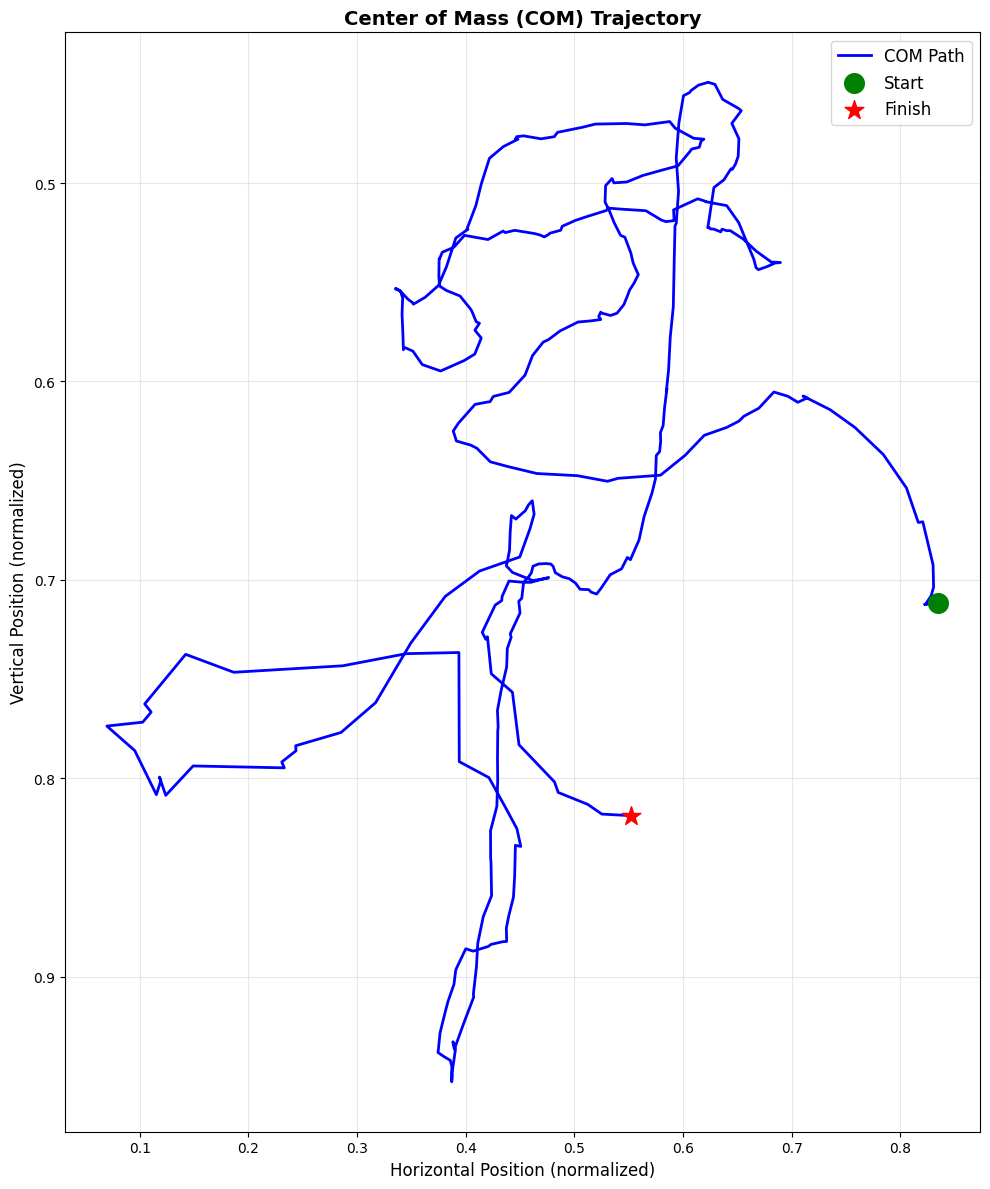

✓ COM trajectory plotted


In [19]:
# Plot COM trajectory
plt.figure(figsize=(10, 12))
plt.plot(com_trajectory[:, 0], com_trajectory[:, 1], 'b-', linewidth=2, label='COM Path')
plt.scatter(com_trajectory[0, 0], com_trajectory[0, 1], c='green', s=200, marker='o', label='Start', zorder=5)
plt.scatter(com_trajectory[-1, 0], com_trajectory[-1, 1], c='red', s=200, marker='*', label='Finish', zorder=5)
plt.xlabel('Horizontal Position (normalized)', fontsize=12)
plt.ylabel('Vertical Position (normalized)', fontsize=12)
plt.title('Center of Mass (COM) Trajectory', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Invert Y (video coordinates: top=0)
plt.tight_layout()
plt.show()

print("✓ COM trajectory plotted")

## 7. Basic Statistics

In [20]:
# Calculate basic metrics
total_time = timestamps[-1] if timestamps else 0
num_frames = len(results)
fps = num_frames / total_time if total_time > 0 else 0
detection_rate = sum(1 for r in results if r['has_detection']) / num_frames * 100

# Path length (normalized coordinates)
path_length = sum(np.linalg.norm(com_trajectory[i] - com_trajectory[i-1])
                  for i in range(1, len(com_trajectory)))

# Straight line distance
straight_distance = np.linalg.norm(com_trajectory[-1] - com_trajectory[0])

# Efficiency
efficiency = straight_distance / path_length if path_length > 0 else 0

print("=== Video Statistics ===")
print(f"Duration: {total_time:.2f} seconds")
print(f"Total frames: {num_frames}")
print(f"FPS: {fps:.2f}")
print(f"Detection rate: {detection_rate:.1f}%")
print(f"\n=== Trajectory Metrics (Normalized) ===")
print(f"Path length: {path_length:.4f}")
print(f"Straight distance: {straight_distance:.4f}")
print(f"Path efficiency: {efficiency:.4f}")
print(f"\nNote: For real-world metrics (meters), camera calibration is needed.")

=== Video Statistics ===
Duration: 12.33 seconds
Total frames: 371
FPS: 30.08
Detection rate: 99.7%

=== Trajectory Metrics (Normalized) ===
Path length: 4.0887
Straight distance: 0.3023
Path efficiency: 0.0739

Note: For real-world metrics (meters), camera calibration is needed.


## 8. Export Data

In [21]:
# Create DataFrame for easy analysis
data = []
for result in results:
    if result['has_detection'] and 'COM' in result['keypoints']:
        com = result['keypoints']['COM']
        data.append({
            'frame_id': result['frame_id'],
            'timestamp': result['timestamp'],
            'com_x': com['x'],
            'com_y': com['y']
        })

df = pd.DataFrame(data)
csv_path = PROJECT_ROOT / 'data' / 'processed' / f"com_trajectory_{input_video.stem}.csv"
df.to_csv(csv_path, index=False)

print(f"✓ COM trajectory saved to CSV: {csv_path}")
print(f"\nFirst 5 rows:")
display(df.head())

✓ COM trajectory saved to CSV: /content/drive/MyDrive/speed_climbing_project/data/processed/com_trajectory_Meet-Ola-Miroslaw-the-fastest-female-speed-climber_Media_720p (1).csv

First 5 rows:


,frame_id,timestamp,com_x,com_y
0,0,0.000000,0.835024,0.711733
1,1,0.033333,0.833608,0.711630
2,2,0.066667,0.832741,0.711442
3,3,0.100000,0.832105,0.711317
4,4,0.133333,0.831561,0.712156


In [22]:
# Download files (Colab only)
if IN_COLAB:
    from google.colab import files
    print("Downloading results...")
    files.download(str(output_json))
    files.download(str(csv_path))
    print("✓ Files downloaded")
else:
    print("Files are saved locally")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Files downloaded


## 9. Next Steps

✅ **Completed:**
- Video processing با OpenCV
- استخراج 33 keypoints با MediaPipe BlazePose
- محاسبه COM trajectory
- ذخیره نتایج (JSON + CSV)
- visualization اولیه

📋 **To-Do:**
1. **Camera Calibration**: تبدیل pixel → meter (IFSC standard wall)
2. **Feature Engineering**: محاسبه path entropy, step length, velocity
3. **Phase 2 Analysis**: گام‌های بعدی با `path_entropy.py`
4. **NARX Training**: جمع‌آوری dataset و آموزش مدل
5. **Fuzzy Logic**: پیاده‌سازی سیستم ارزیابی

---

### Continue to Notebook 02: Feature Extraction 🚀